In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import os
from scipy.interpolate import UnivariateSpline
from scipy.sparse import dok_matrix
import numpy as np
import pickle

InTeslaOverGeV2 = 1.69041E+16
InGeVcm = 1.97327E-14
IncmOverns = 29.9792
InMeV = 1000.

UnitsRS = (InTeslaOverGeV2 * InGeVcm)
UnitsOmegaS = (IncmOverns / (InTeslaOverGeV2 * InGeVcm))
UnitsTime = IncmOverns

In [165]:
data_dir = "/Users/dlinthorne/Projects/MISC/IDsym_Daniel_&_Dylan/"

atlas_dir = data_dir + "PythonSym/"
hep_file = data_dir + "truth/signal_ev_truth.hepmc"
tracker_file_temp = data_dir + "tracker/" + "signal_ev_truth.hepmc".replace("truth", "tracker_LAYERID").replace(".hepmc",
                                                                                                           ".txt")
tracker_file_list = [tracker_file_temp.replace("LAYERID", str(idx-1)) for idx in range(1, 5)]

atlas_bfield = 2

In [166]:
def get_pdg_code(name):
    switcher = {
        "e+": -11,
        "e-": 11,
        "mu+": -13,
        "mu-": 13,
        "met": 12,
        "ga": 22,
        "pi+": 211,
        "pi-": -211
    }
    return switcher.get(name, "nothing")

def sub_pdg_code(name):
    switcher = {
        -11: "e+",
        11: "e-",
        -13: "mu+",
        13: "mu-",
        12: "met",
        22: "ga",
        211: "pi+",
        -211: "pi-"
    }
    return switcher.get(name, "nothing")

In [167]:
def rad_from_xy(x, y):
    return np.sqrt(x**2 + y**2)

In [168]:
def pt_four_vec(px, py, pz, e, m):

    mod = np.sqrt(px**2. + py**2.)
    if mod != 0.:
        return [mod, np.arctan2(py, px), np.arctanh(pz/np.sqrt(mod**2.+ pz**2.)), m]
    else:
        return [0., 0., float('Inf')*np.sign(pz), m]


In [201]:
def z_from_eta_r(eta, r):
    """
    Returns:
    z   -- object's longitudinal coordinate aligned with beam axis
    """
    return r * np.sinh(eta)

In [202]:
def r_from_eta_z(eta, z):
    """
    Returns:
    r -- radial distance from the beamline
    """
    if eta != 0.:
        return z / np.sinh(eta)
    elif z == 0.:
        return 0.
    else:
        return float('Inf')

In [298]:
def pt_four_vec(px, py, pz, e, m):
    '''

    :param px: x momentum
    :param py: y momentum
    :param pz: z momentum
    :param e: energy
    :param m: rest mass
    :return: [pt, phi, eta, m]
    '''
    pmod = np.sqrt(px**2. + py**2.)
    if pmod != 0.:
        return [pmod, np.arctan2(py, px), np.arctanh(pz/np.sqrt(pmod**2.+pz**2.)), m]
    else:
        return [0., 0., float('Inf')*np.sign(pz), m]

array(0.02259132)

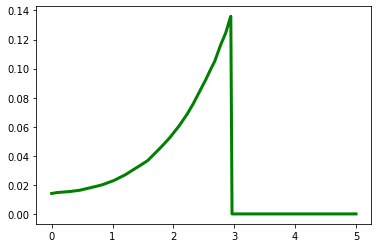

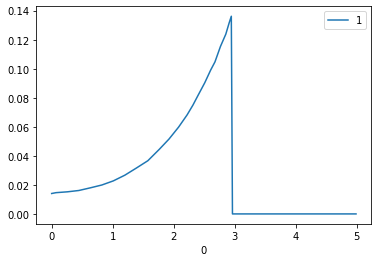

In [231]:
def read_grid(fname, with_header=True):
    """
    Arguments:
    fname  -- file path to grids
    with_header -- flag on whether grid files have header data

    Returns:
    func   -- list of interpolated splines of layer grids
    ranges -- list of layer dimensions in (r,?, length in z) [mm]
    """
    ranges = []
    header_flag = 0
    if with_header:
        with open(fname, 'r') as f:
            ranges = [float(x) for x in f.readline().split(',')]
        header_flag = 1

    vals = np.genfromtxt(fname, delimiter=',', skip_header=header_flag)
    funcs = [UnivariateSpline(vals[:, 0], vals[:, i], k=1) for i in range(1, len(vals[0]))]
    [elem.set_smoothing_factor(0.) for elem in funcs]

    return [funcs, ranges]

raw_df = pd.read_csv(atlas_dir + 'ATLASEMlossIBL.csv', skiprows=1, header=None)
ibl_spline, ibl_range = read_grid(atlas_dir + 'ATLASEMlossIBL.csv')
xs = np.linspace(0, 5, 1000)
plt.plot(xs, ibl_spline[0](xs), 'g', lw=3)
raw_df.plot(x = 0, y = 1)
ibl_spline[0](1)

In [251]:
def init_layers_atlas(atlas_dir ="/Users/dlinthorne/Projects/MISC/IDsym_Daniel_&_Dylan/PythonSym/"):
    """
    Initializes the tracking layers using ATLAS geometric specifications:
    PIPE -> IBL -> PIXEL -> SCT -> TRT

    Arguments:
    ATLASdir -- path to ATLAS geometry files

    Returns: [position, loss_function, detector_size, isHoriz]
    layers_e -- interpolated slines of each layer relevant for electron propagation
    layers_mu -- interpolated slines of each layer relevant for muon propagation
    layers_pi -- interpolated slines of each layer relevant for pion propagation

    for horizantal elements position is (r,abs(z)_min,abs(z)_max)
    fand detector size is (dphi, dr, dz)
    loss_function is spline function of eta_position
    last layer is calo. dr is None and instead of dz it's deta.
    """

    ibl = read_grid(atlas_dir + 'ATLASEMlossIBL.csv')
    pixel_barrel = [read_grid(atlas_dir + 'ATLASEMlossPixelB' + str(i) + '.csv') for i in range(1, 4)]
    sct_barrel = [read_grid(atlas_dir + 'ATLASEMlossSctB' + str(i) + '.csv') for i in range(1, 5)]
    trt_barrel = [read_grid(atlas_dir + 'ATLASEMlossTRTB' + str(i) + '.csv') for i in range(1, 5)]

    dummy_loss = lambda x: 0.

    # Dimensions (R, ?, Z Length) [cm]
    layer_positions = ([ibl[1]] + [pixel_barrel[i][1] for i in range(0, 3)]
                       + [sct_barrel[i][1] for i in range(0, 4)]
                       + [trt_barrel[i][1] for i in range(0, 4)]
                       + [[115., 0, z_from_eta_r(1.5, 115.)],
                          [r_from_eta_z(3.5, z_from_eta_r(1.5, 115.)), 115., z_from_eta_r(1.5, 115.)]])

    layer_em_loss = ([ibl[0][0]] + [pixel_barrel[i][0][0] for i in range(0, 3)]
                     + [sct_barrel[i][0][0] for i in range(0, 4)]
                     + [trt_barrel[i][0][0] for i in range(0, 4)]
                     + [dummy_loss, dummy_loss])

    layer_dummy_loss = [dummy_loss for i in range(0, len(layer_positions))]

    #todo: to be changed once grids are available

    layer_had_loss = layer_dummy_loss

    layer_dimensions = ([[0.005 / ibl[1][0], 0.025, 0.023]]
                        + [[0.005 / pixel_barrel[i][1][0], 0.04, 0.025] for i in range(0, 3)]
                        + [[0.008 / sct_barrel[i][1][0], 6.39, 0.0285] for i in range(0, 4)]
                        + [[None, None, None] for i in range(0, 4)]
                        + [[2. * np.pi / 256., 0.025, None], [2. * np.pi / 256., 0.025, None]])

    layer_orient = (  [True]
                    + [True, True, True]
                    + [True, True, True, True]
                    + [True, True, True, True]
                    + [True, False])

    layers_e = [[a, b, c, d] for a, b, c, d in zip(layer_positions, layer_em_loss, layer_dimensions, layer_orient)]
    layers_mu = [[a, b, c, d] for a, b, c, d in zip(layer_positions, layer_dummy_loss, layer_dimensions, layer_orient)]
    layers_pi = [[a, b, c, d] for a, b, c, d in zip(layer_positions, layer_had_loss, layer_dimensions, layer_orient)]

    return (layers_e, layers_mu, layers_pi)


In [314]:
layers_e = init_layers_atlas()[0][:-1]
#detector_size = np.array(layers_e)[:,2]
#detector_position = np.array(layers_e)[:,0]

'''
[position, loss_function, detector_size, isHoriz]
position is (r,abs(z)_min,abs(z)_max)
detector size is (dphi, dr, dz)
    where dr is the seperation between layers
loss_function is spline function of eta_position
'''

layerHits = [dok_matrix((int(np.ceil(2. * np.pi / x[2][0])), int(2. * np.ceil((x[0][2] - x[0][1]) / x[2][1]))))
             if x[2][2] is not None else None for x in layers_e]

#layerHits
#layers_e[0][2][0]
#test = [x for x in layers_e]

In [303]:
def Px(ptphietam):
    return ptphietam[0] * np.cos(ptphietam[1])

def Py(ptphietam):
    return ptphietam[0] * np.sin(ptphietam[1])

def Pz(ptphietam):
    return ptphietam[0] * np.sinh(ptphietam[2])

def Pmod(ptphietam):
    return ptphietam[0] * np.cosh(ptphietam[2])

def Energy(ptphietam):
    return np.sqrt(Pmod(ptphietam)**2. + ptphietam[3]**2)

In [311]:
def RCycl(ptphietam, q, B):
    tmp = 0.0
    try:
        tmp = ptphietam[0] / (B * abs(q)) * UnitsRS
    except:
        return float('Inf')
    else:
        return tmp

def OmegaCycl(ptphietam, q, B):
    tmp = 0.0
    try:
        tmp = (B * abs(q)) / Energy(ptphietam) * UnitsOmegaS
    except:
        return float('Inf')
    else:
        return tmp

In [ ]:
def CanReachR(nextR, rcenter, rcycl):
    return (nextR >= abs(rcenter-rcycl)) and (nextR <= rcenter + rcycl)

def NextTimeFromR(nextR, t0, omega, q, rcenter, phicenter, rcycl, phicycl):
    delta = 0.
    if CanReachR(nextR, rcenter, rcycl):
        delta = np.arccos((nextR**2. - rcenter**2. - rcycl**2.) / (2.*rcenter*rcycl))
    else:
        return float('Inf')

    deltatp = 1./(np.sign(q)*omega)*(np.fmod(delta - phicycl + phicenter, 2.*np.pi))
    deltatm = 1./(np.sign(q)*omega)*(np.fmod(-delta - phicycl + phicenter, 2.*np.pi))
    deltaperiod = 1./(np.sign(q)*omega)*2*np.pi

    return t0 + min([x for x in ([deltatp + i*deltaperiod for i in range(-1, 2)]
                                 + [deltatm + i*deltaperiod for i in range(-1, 2)])
                     if x > (1.e-10/omega)])

def NextTimeFromZ(nextZ, t0, zcenter, ptphietam):
    tmp = 0.
    try:
        tmp = ((nextZ - zcenter) * Energy(ptphietam) /
               (Pz(ptphietam) * UnitsTime))
        if tmp >= 0.:
            return tmp + t0
        else:
            return float('Inf')
    except:
        return float('Inf')

def PickNextLayer(ptphietam, q, omega, t, rcenter, phicenter, rcycl, phicycl, zcenter, layers):

    zcut = z_from_eta_r(1.5, 115.)*1.01
    rcut = 115.*1.01
    tvals0 = [NextTimeFromR(elem[0][0], t, omega, q, rcenter, phicenter, rcycl, phicycl)  if elem[3] else
              NextTimeFromZ(np.sign(ptphietam[2])*elem[0][2], t, zcenter, ptphietam) for elem in layers]

    tvals1 = [tval if tval > t and not np.isinf(tval) else None for tval in
              tvals0 ]
    time_vals = [tval if ((tval is not None) and
                          ((elem[3] and
                            ((elem[0][1] <= ZAtTime(ptphietam, tval, t,
                                                    zcenter)
                              <= elem[0][2]) or
                             (-elem[0][2] <= ZAtTime(ptphietam, tval, t,
                                                     zcenter)
                              <= -elem[0][1])))
                           or ((not elem[3]) and (elem[0][0] <=
                                                  RAtTime(tval, t, omega, q, rcenter, phicenter,
                                                          rcycl, phicycl) <= elem[0][1])))
                          and (abs(ZAtTime(ptphietam, tval, t, zcenter)) < zcut)
                          and (RAtTime(tval, t, omega, q, rcenter, phicenter,
                                       rcycl, phicycl) < rcut))
                 else None for tval, elem in zip(tvals1, layers)]
    valt = t
    idxt = -1
    try:
        valt, idxt = min((val, idx) for (idx, val) in enumerate(time_vals)
                         if val is not None)
    except:
        pass
    return idxt, valt

def propagate(ptphietamIn, q, Bfield, originRPhiZ, layers):
    # print "----"
    timeouts = [0]*len(layers)
    ptphietam = ptphietamIn
    t = 0.
    tcut_tracker = 25.
    tcut_calo = 100.
    deltaz = 0.

    omega = OmegaCycl(ptphietam, q, Bfield)
    rcycl = RCycl(ptphietam, q, Bfield)
    phicycl = ptphietam[1]-np.pi/2.*np.sign(q)
    phicenter = ptphietam[1]+np.pi/2.*np.sign(q)

    rcenter = np.sqrt(originRPhiZ[0]**2. + rcycl**2.
                      + 2. * originRPhiZ[0] * rcycl *np.cos(phicenter - originRPhiZ[1]))
    phicenter = np.arctan2(originRPhiZ[0] * np.sin(originRPhiZ[1]) + rcycl * np.sin(phicenter),
                           originRPhiZ[0] * np.cos(originRPhiZ[1]) + rcycl * np.cos(phicenter))
    zcenter = originRPhiZ[2] + deltaz

    layerId = -1
    tnext = t

    #if not np.isinf(omega):
    #    layerId, tnext = PickNextLayer(ptphietam, q, omega, t, rcenter, phicenter,
    #                                   rcycl, phicycl, zcenter, layers)

In [312]:
vertex_list = []
bfield = 2
i = 0
with open(hep_file, encoding = 'utf-8') as f:
    for index, line in enumerate(f):
        line_vect = np.array(line.split(" "))
        branch_type = line_vect[0]
        if branch_type == "E":
            print("Line {}: {}".format(index, line.strip()))
            i = i + 1
        if branch_type == "V" and i == 1:
            max_barcode = 0
            vertex_pos = line_vect[3:7].astype(float)
            num_in = line_vect[7].astype(float)
            num_out = line_vect[8].astype(float)
            num_particle = num_in + num_out

            if np.sum(vertex_pos) != 0:
                max_barcode = 0
                #print("Line {}: {}".format(index, line.strip()))
                #print(vertex_pos.shape)
                ver_radial = rad_from_xy(vertex_pos[0], vertex_pos[1])
                ver_phi = np.arctan2(vertex_pos[0], vertex_pos[1])
                ver_z = vertex_pos[2]
                ver_time = vertex_pos[3]
                vpos = [ver_radial/10, ver_phi, ver_z/10]
                #print(f"Radial distance = {ver_radial/10}")
                #print(f"Z distance = {ver_z/10}")
                vertex_list.append([ver_radial,ver_phi, ver_z, ver_time])

                particles = [f.readline().split() for x in range(int(num_particle))]
                max_barcode = max([max_barcode]+[int(x[1]) for x in particles])
                #print(particles[0])

                readyparticles = [x for x in particles if x[8] != '1'
                                  or abs(int(x[2])) not in [11, 13, 211, 321]
                                  or abs(np.arctanh(float(x[5])/np.sqrt(float(x[3])**2
                                         + float(x[4])**2+float(x[5])**2))) > 3.5]

                #todo figure out decay vs undecayed
                particle_list = [x for x in particles if abs(int(x[2])) in [11, 13, 211, 321]
                                 and abs(np.arctanh(float(x[5])/np.sqrt(float(x[3])**2
                                         + float(x[4])**2 + float(x[5])**2))) <= 3.5]
                #print(particle_list)
                for particle in particle_list:
                    particle_node = np.array(particle)
                    particle_vect = particle_node[3:8].astype(float)
                    pdg_code = particle_node[2].astype(float)
                    pdg_name = sub_pdg_code(pdg_code)
                    barcode = int(particle[1])

                    ptphietam = pt_four_vec(particle_vect[0], particle_vect[1],
                                            particle_vect[2], particle_vect[3],
                                            particle_vect[4])
                    print(ptphietam)
                    if abs(pdg_code) == 11:
                        #calopart, tmphits, tmpphos, tmptimeouts = propagate(ptphietam, -np.sign(pdg_code),bfield, vpos, ion_e, layers_e, 0., True, True)
                        propagate(ptphietam,-np.sign(pdg_code), bfield, vpos, layers_e)

                #    particle_pt_vect = pt_four_vec(particle_vect[0], particle_vect[1], particle_vect[2], particle_vect[3], particle_vect[4])
                #if ver_radial/1000 < 1000 :
                #        print(f"Radial distance = {ver_radial/1000}")
                #        print(f"Z distance = {ver_z/1000}")
                #        print(pdg_name)


Line 3: E 0 -1 -1.0000000000000000e+00 -1.0000000000000000e+00 -1.0000000000000000e+00 0 0 2433 1 2 0 0
[17.81317013248662, 1.6762695256136053, -0.9637993314049871, 0.13957]
[3.2913003479955245, 1.714882669136895, -1.1143292597967867, 0.13957]
[3.766245017882683, 1.6264458143818656, -0.3768121746963114, 0.13957]
[4.353138841706016, 1.9064037069910393, -0.2667682767739599, 0.13957]
[0.5253337324345578, -0.9377752023644897, -0.821455312880897, 0.13957]
[0.12056167747200384, -2.4470314508867017, 0.3229007159178834, 0.13957]
[0.6315608847465778, 3.05753365050352, -0.6080299277846606, 0.13957]
[1.2423694428237495, -2.8634611646412833, 0.2835770153511815, 0.49368]
[1.467235585897775, -1.7324204154376672, 0.557806555625099, 0.49368]
[0.21510216823336864, -2.5125770774711897, 3.19393984869956, 0.10566]
[0.8350340973769455, 0.6463950214424493, -3.3374180578670085, 0.13957]
[1.0523809172830734, 0.6276555523686967, -3.2795935702527848, 0.13957]
[1.4138468772911077, 0.5347098433515667, -0.06142550